In [2]:
import sys
#Change path specificly to your directories
sys.path.insert(1, '/home/codahead/Fishial/FishialReaserch')
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, json
from shapely.geometry import Polygon
import random
import os
import json
import copy
from tqdm import tqdm
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, json
from shapely.geometry import Polygon
import random
import imutils
import numpy as np
from PIL import Image
from module.segmentation_package.src.visualize import display_instances
from module.segmentation_package.src.utils import get_dataset_dicts
from pycocotools import mask


def get_image_class(data, image_id):
    for i in data['images']:
        if i['id'] == image_id:
            return i


def read_json(data):
    with open(data) as f:
        return json.load(f)


def save_json(data, path):
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(data, f)


def get_mask(image, segm):
    polygon = []

    for i in range(int(len(segm) / 2)):
        polygon.append([int(segm[2 * i]), int(segm[2 * i + 1])])

    pts = np.array(polygon)
    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    croped = image.copy()

    ## (2) make mask
    pts = pts

    croped_binary_mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(croped_binary_mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=croped_binary_mask)
    return dst, croped_binary_mask, rect, polygon


def get_images(instance):
    file_name    = instance['file_name']
    segmentation = instance['segmentation']
    
    img_full = cv2.imread(file_name)
    img_full = cv2.cvtColor(img_full, cv2.COLOR_BGR2RGB)
    full_mask, binary_mask, rect, pts = get_mask(img_full, segmentation)
    x, y, w, h = rect #[y:y + h, x:x + w] #[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
    return {
        'image_full': img_full,
        'full_mask': full_mask,
        'binary_mask': binary_mask,
        'rect': [max(0, x), max(0, y), w, h],
        'segmentation': pts
    }

def get_images_from_instance(data_instance, dst_size=(1440, 1440)):

    img_full = cv2.imread(data_instance['file_name'])
    img_full = cv2.cvtColor(img_full, cv2.COLOR_BGR2RGB)
    src_size = img_full.shape[:2]
    
    img_full = cv2.resize(img_full, dst_size)
    
    scale = (src_size[0]/dst_size[0], src_size[1]/dst_size[1])
    
    img_data = {
        'image_full': img_full,
        'full_mask': [],
        'binary_mask': [],
        'rect': [],
        'segmentation': []
    }
    
    for i in data_instance['annotations']:
        new_segm_points = []
        for poin_seg in range(int(len(i['segmentation'][0])/2)):
            new_segm_points.append(i['segmentation'][0][2 * poin_seg] / scale[1])
            new_segm_points.append(i['segmentation'][0][2 * poin_seg + 1] / scale[0])
        full_mask, binary_mask, rect, pts = get_mask(img_full, new_segm_points)
        x, y, w, h = rect #[y:y + h, x:x + w] #[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
        img_data['full_mask'].append(full_mask)
        img_data['binary_mask'].append(binary_mask)
        img_data['rect'].append([max(0, x), max(0, y), w, h])
        img_data['segmentation'].append(pts)
        
    return img_data


def overlap2(rect1,rect2):
    p1 = Polygon([(rect1[0],rect1[1]), (rect1[0] + rect1[2], rect1[1]),(rect1[0] + rect1[2],rect1[1] + rect1[3]),(rect1[0],rect1[1] + rect1[3])])
    p2 = Polygon([(rect2[0],rect2[1]), (rect2[0] + rect2[2], rect2[1]),(rect2[0] + rect2[2],rect2[1] + rect2[3]),(rect2[0],rect2[1] + rect2[3])])
    intersection = p1.intersection(p2)
    return intersection.area
        
def check_fit(rectangles, rectangle):
    for i in rectangles:
        if overlap2(i, rectangle) > 0.0:
            return True
    return False

def get_copy_paste_instance(dataset):
    data_valid_ann = []
    for i in dataset:
        for z in i['annotations']:
            x_points = []
            y_points = []
            for point_id in range(int(len(z['segmentation'][0])/2)):
                x_points.append(z['segmentation'][0][2 * point_id])
                y_points.append(z['segmentation'][0][2 * point_id + 1])
            width = max(x_points) - min(x_points)
            height = max(y_points) - min(y_points)
            if width > 240 and height > 240:
                data_valid_ann.append({
                    'file_name'   : i['file_name'],
                    'segmentation': z['segmentation'][0]
                })
    return data_valid_ann
                
def generate_free_area(rectangles, size, max_box = 4):
    list_x = [[i[0], i[0]+i[2]] for i in rectangles]  
    list_x.append([0, size[1]])
    list_x = np.array(list_x).reshape(-1)
    list_x.sort()
    list_y = [[i[1], i[1]+i[3]] for i in rectangles]
    list_y.append([0, size[0]])
    list_y = np.array(list_y).reshape(-1)
    list_y.sort()
    
    all_posible_rectangles = []
    all_points = [[i, z] for z in list_y for ii, i in enumerate(list_x)]
    for i in all_points:
        for k in all_points[1:]:
            if i[0] != k[0] and i[1] != k[1]:
                rect = [i[0], i[1], k[0] - i[0], k[1] - i[1]]
                if min(rect) < 0: continue  
                state = check_fit(rectangles, rect)
                if not state:
                    all_posible_rectangles.append([rect, rect[2] * rect[3]])

    all_posible_rectangles = sorted(all_posible_rectangles, key=lambda x: x[1], reverse=False)
    id_to_remove = []
    for first in range(len(all_posible_rectangles)-1, -1, -1):
        if first in id_to_remove:
            continue
        for second in range(first-1, -1, -1):
            if overlap2(all_posible_rectangles[first][0], all_posible_rectangles[second][0]) > 0:
                id_to_remove.append(second)

    id_to_remove = list(set(id_to_remove))
    id_to_remove.sort(reverse=True)
    for i in id_to_remove:
        del all_posible_rectangles[i]
    all_posible_rectangles = sorted(all_posible_rectangles, key=lambda x: x[1], reverse=True)
    return [i[0] for i in all_posible_rectangles]


def resize_image(img, scale):
    w,h = img.shape[:2]
    imS = cv2.resize(img, ( int(h * scale), int(w * scale)))
    return imS

def get_orient(size):
    return 'horizontal' if size[0] > size[1] else 'vertical'

def check_size(rect, area, max_ratio = 9, min_area_ratio = 0.05):
    area_val = (rect[2] * rect[3])/(area[0] * area[1])
    ratio = rect[2] / rect[3]
    if ratio > max_ratio or ratio < 1/max_ratio:
        return False
    if area_val < min_area_ratio:
        return False
    return True

def get_rotate_angle(paste_box, input_mask):
    paste_box_state = 0
    input_mask_state = 0
    if paste_box[2]>paste_box[3]:
        paste_box_state = 1
    if input_mask[2]>input_mask[3]:
        input_mask_state = 1
        
    if paste_box_state == input_mask_state:
        return 1
    return 0 #ROTATE_90_CLOCKWISE


def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by 45 degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha
    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop
    return img_crop


def apply_mask(src, src_mask_origin, color_mask, binary_mask, angle, box, polygon, min_ratio = 0.025):
    
    if angle != 1:
        color_mask = cv2.rotate(color_mask, cv2.cv2.ROTATE_90_CLOCKWISE)
        binary_mask = cv2.rotate(binary_mask, cv2.cv2.ROTATE_90_CLOCKWISE)
        w, h = color_mask.shape[:2]
        for p_a in range(len(polygon)):
            tmp_x, tmp_y = polygon[p_a][0], polygon[p_a][1]
            polygon[p_a][0] = h - tmp_y
            polygon[p_a][1] = tmp_x
    
    mask_size = binary_mask.shape[:2]
    
    if min(mask_size) < 50:
        return False, src, src_mask_origin, None
    scaling = round(min(box[2]/mask_size[0], box[3]/mask_size[1]), 3)
    
    if scaling < 1:
        scaling = scaling * 0.95
        color_mask = resize_image(color_mask, scaling)
        binary_mask = resize_image(binary_mask, scaling)
        
        for p_a in range(len(polygon)):
            polygon[p_a][0] = int(polygon[p_a][0] * scaling)
            polygon[p_a][1] = int(polygon[p_a][1] * scaling)
            
        
    
    mask_size = binary_mask.shape[:2]
    
    box_width = box[2]
    box_height = box[3]
    
    area_full = src.shape[0] * src.shape[1]
    area_mask = binary_mask.shape[0] * binary_mask.shape[1]
    
    if area_mask/area_full < min_ratio:
        return False, src, src_mask_origin, None
    
    mask_height, mask_width = mask_size
        
    off_y = random.randint(0,box_height - mask_height)
    off_x = random.randint(0,box_width - mask_width)
        
    offset = np.array((box[0] + off_x, box[1] + off_y))
    
    binary_mask_croped = binary_mask / 255.0
    binary_mask_origin = src_mask_origin / 255.0

    overlay_image_alpha(src, color_mask, offset[0], offset[1],  binary_mask_croped)
    
    zeros_matrix = np.zeros(binary_mask_origin.shape[:2], np.uint8)
    
    zeros_matrix[offset[1]:offset[1]+binary_mask_croped.shape[0],offset[0]:offset[0]+binary_mask_croped.shape[1]] = binary_mask_croped
    paste_rect = [offset[0], offset[1], binary_mask_croped.shape[1], binary_mask_croped.shape[0]]
    
    for p_a in range(len(polygon)):
        polygon[p_a][0] = polygon[p_a][0] + offset[0] 
        polygon[p_a][1] = polygon[p_a][1] + offset[1]
    
    return True, zeros_matrix, paste_rect, polygon

def apply_copy_paste_aug(target_instance, data_valid_paste):
    target = get_images_from_instance(target_instance)
    
    src = target['image_full'].copy()
    rectangles = []

    ix = 0
    img_data = {
        'image': src,
        'segmentation': []
    }
    
    for id_current in range(len(target['rect'])):
        rectangles.append(target['rect'][id_current])
        b_box = [target['rect'][id_current][0], target['rect'][id_current][1],target['rect'][id_current][2],target['rect'][id_current][3]]
        img_data['segmentation'].append(target['segmentation'][id_current])
        ix += 1
    if len(img_data['segmentation']) > 1: return img_data

    paste_aug = random.sample(data_valid_paste, random.randint(1,5))

    for paste_aug_id in paste_aug:
        try:
            aug_img = get_images(paste_aug_id)
            rect_aug = aug_img['rect']
            full_mask = aug_img['full_mask'][rect_aug[1]:rect_aug[1] + rect_aug[3], rect_aug[0]:rect_aug[0] + rect_aug[2]]
            size_src_img = target['image_full'][0].shape[:2]
            all_free_places = generate_free_area(rectangles, (size_src_img[1], size_src_img[0]))
            if len(all_free_places) == 0:
                print("Stop none of empty areas")
                break

            i = all_free_places[0]

            target_image_size = target['full_mask'][0].shape[:2]
            state = check_size(i, target_image_size)
            if not state:
                print("Fish size isn't valid")
                break

            angle = get_rotate_angle(i,rect_aug)

            src_mask_origin = target['binary_mask'][0].copy()
            color_mask = aug_img['full_mask'][rect_aug[1]:rect_aug[1] + rect_aug[3], rect_aug[0]:rect_aug[0] + rect_aug[2]].copy()
            binary_mask = aug_img['binary_mask'][rect_aug[1]:rect_aug[1] + rect_aug[3], rect_aug[0]:rect_aug[0] + rect_aug[2]].copy()

            # Perfom that in preprocess function
            for p_a in range(len(aug_img['segmentation'])):
                aug_img['segmentation'][p_a][0] = aug_img['segmentation'][p_a][0] - rect_aug[0] 
                aug_img['segmentation'][p_a][1] = aug_img['segmentation'][p_a][1] - rect_aug[1]

            statet, binary_mask_origin, paste_rect, poly = apply_mask(src, src_mask_origin, color_mask, binary_mask, angle, i, aug_img['segmentation'])
            if not statet: continue
#             b_box = [paste_rect[0], paste_rect[1], paste_rect[2], paste_rect[3]]
#             img_data['bboxes'].append(b_box + [0] + [ix])

#             img_data['masks'].append(binary_mask_origin.copy())
            img_data['segmentation'].append(poly)
            rectangles.append(paste_rect)
            ix += 1
        except Exception as e:
            print(f"error: {e}")
            pass
            
    return img_data

In [3]:
dataset = get_dataset_dicts('FishialReaserch/datasets/fishial_collection/cache', 'Test', json_file="FishialReaserch/datasets/fishial_collection/export.json")
data_valid_ann = get_copy_paste_instance(dataset)

Left: 23222 skip: 2537

Left: 21924 skip: 3339

Left: 21016 skip: 4075

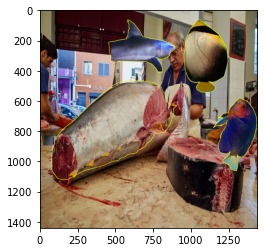

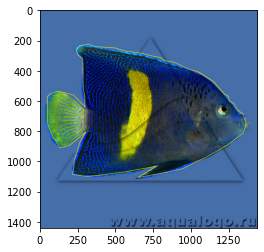

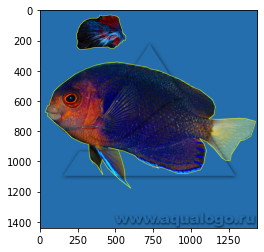

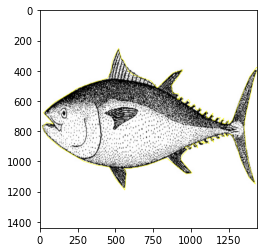

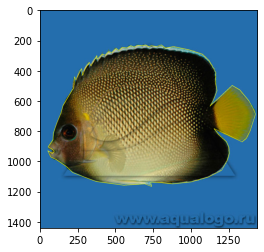

Fish size isn't valid


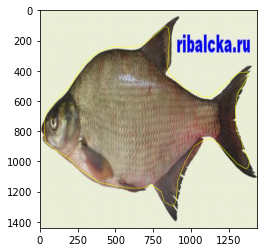

Stop none of empty areas


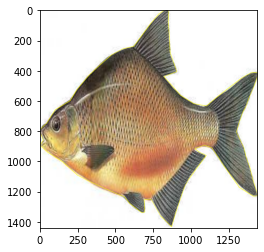

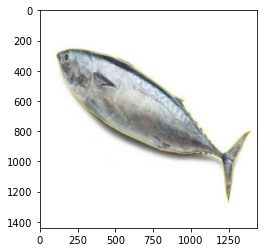

Fish size isn't valid


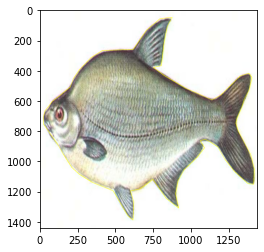

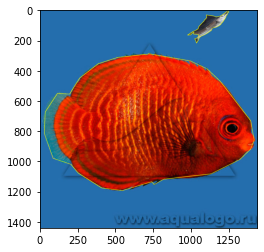

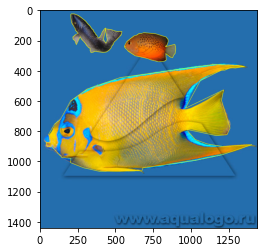

Fish size isn't valid


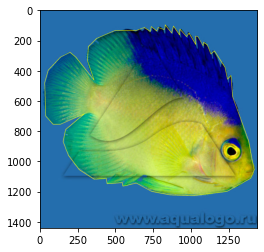

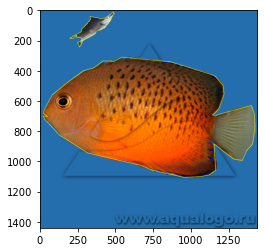

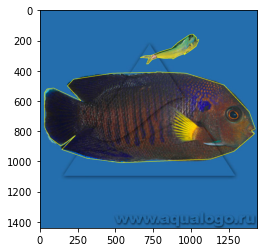

In [8]:
for indices in range(20):
    if len(dataset[indices]['annotations']) > 1:
        continue
    img_data = apply_copy_paste_aug(dataset[indices], data_valid_ann)

    image = img_data['image']
    segmentation = img_data['segmentation']
    for i in segmentation:
        coco_poly = []
        for pts in i:
            coco_poly.append(pts[0])
            coco_poly.append(pts[1])
        color = (255, 255, 0)
        # Line thickness of 2 px
        thickness = 2
        image = cv2.polylines(image, [np.array(i)], 
                              True, color, thickness)
    plt.imshow(image)
    plt.show()